In [43]:
import torch
from torch import nn, optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from tqdm import tqdm

%matplotlib inline

In [44]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [45]:
mu1 = torch.tensor([10., 3.], device=device, dtype=torch.float32)
mu2 = torch.tensor([5., 0.], device=device, dtype=torch.float32)
covar = torch.tensor([[1., 0.], [0., 1.]], device=device, dtype=torch.float32)

p = 0.6
N = 10000
batch_size = 100
num_epoches = 250
z_dim = 2

In [46]:
c = torch.distributions.Bernoulli(p). sample((N, )).to(device).view(-1, 1)
a = torch.distributions.MultivariateNormal(loc=mu1, covariance_matrix=covar).sample((N, ))
b = torch.distributions.MultivariateNormal(loc=mu2, covariance_matrix=covar).sample((N, ))

In [47]:
X = c * a + (1 - c) * b

In [48]:
Y = torch.cat((X, c), 1)
print(Y)

tensor([[ 4.1841, -0.4641,  0.0000],
        [10.9730,  3.8584,  1.0000],
        [10.2126,  4.4642,  1.0000],
        ...,
        [11.1791,  0.1046,  1.0000],
        [10.3097,  2.7942,  1.0000],
        [10.2386,  2.1939,  1.0000]], device='cuda:0')


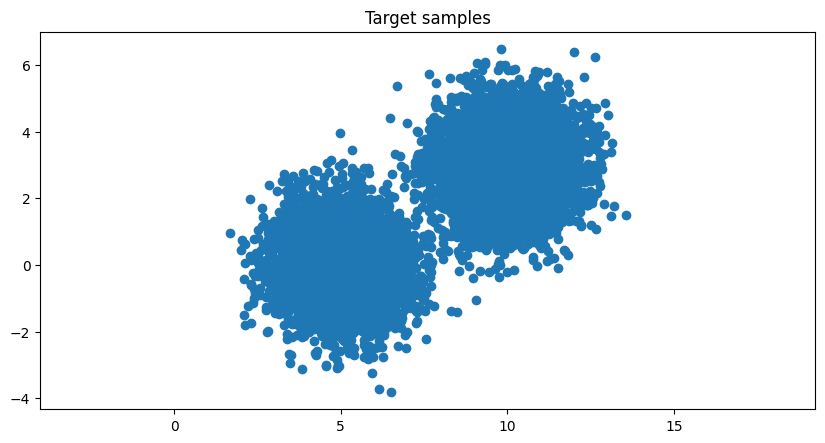

In [49]:
plt.figure(figsize=(10, 5), dpi=100)
plt.title('Target samples')
plt.axis('equal')
plt.scatter(Y[:, 0].cpu(), Y[:, 1].cpu());

In [50]:
class VAE_MoG_prior(nn.Module):
  def __init__(self):
    super(VAE_MoG_prior, self).__init__()

    self.fc0 = nn.Linear(2, 5) # for encoder
    self.fc1 = nn.Linear(5, 10)
    self.fc2 = nn.Linear(10, z_dim) 
    self.fc3 = nn.Linear(10, z_dim)

    self.fc4 = nn.Linear(z_dim, 10) # for decoder
    self.fc5 = nn.Linear(10, 5)
    self.fc6 = nn.Linear(5, 2)

    """
    self.p = nn.Parameter(torch.Tensor([0,5]), requires_grad=False)
    self.m_1 = nn.Parameter(torch.zeros(2))
    self.m_2 = nn.Parameter(torch.zeros(2))
    self.logvar_1 = nn.Parameter(torch.zeros(2))
    self.logvar_2 = nn.Parameter(torch.zeros(2))
    """
    
  def encode(self, x):
    h = torch.relu(self.fc0(x))
    g = torch.relu(self.fc1(h))
    return self.fc2(g), self.fc3(g) # mu and logvar -- parameters of q_{phi}
    
  def reparametrize(self, mu, logvar):
    std = torch.exp(logvar)
    eps = torch.randn_like(std)
    return mu + eps * std
  
  def decode(self, z):
    h = torch.relu(self.fc4(z))
    g = torch.relu(self.fc5(h))
    return self.fc6(g) # mu_0 -- parameter of p_{theta}

  def forward(self, x):
    mu, logvar = self.encode(x)
    z = self.reparametrize(mu, logvar)
    #p, m_1, m_2, logvar_1, logvar_2 = self.get_prior_par(x)
    return self.decode(z), mu, logvar

In [51]:
model = VAE_MoG_prior().to(device)

In [52]:
p = nn.Parameter(torch.Tensor([0,5]), requires_grad=False).to(device)
m_1 = nn.Parameter(torch.zeros(2), requires_grad=True).to(device)
m_2 = nn.Parameter(torch.zeros(2), requires_grad=True).to(device)
logvar_1 = nn.Parameter(torch.zeros(2), requires_grad=True).to(device)
logvar_2 = nn.Parameter(torch.zeros(2), requires_grad=True).to(device)

In [53]:
params = list(model.parameters()) + [p, m_1, logvar_1, m_2, logvar_2]

In [54]:
optimizer = optim.Adam(params=params, lr=1e-3)

ValueError: ignored

$L = KL - ELH = -(\mathbb{E}_{q_{\phi}(z|x)}\log{p_{\theta}(z|x)} - KL(q_{\phi}(z|x)||p(z))) = -(\mathbb{E}_{q_{\phi}(z|x)}\log{p_{\theta}(z|x)} - \mathbb{E}_{q_{\phi}(z|x)}(\log{q_{\phi}(z|x)} - \log{p(z)}))$

$\mathbb{E}_{q_{\phi}(z|x)}\log{q_{\phi}(z|x)} = \int q_{\phi}(z|x)\log{q_{\phi}(z|x)}dz = -\frac{J}{2}\log{2\pi} - \frac{1}{2}\sum_{j = 1}^{J}{(1+\log{\sigma_{j}^{2}})}$

In [54]:
"""
def loss_function(x, mu_0, mu, logvar, p, m_1, m_2, logvar_1, logvar_2): # mu_0 -- mean of p_{theta}; mu, logvar -- parameters of q_{phi}, p, m_1, m_2, logvar_1, logvar_2 -- parameters of prior p(z)
  q_phi = torch.distributions.normal.Normal(loc = mu, scale = logvar.exp())
  g_1 = torch.distributions.normal.Normal(loc = m_1, scale = logvar_1.exp())
  g_2 = torch.distributions.normal.Normal(loc = m_2, scale = logvar_2.exp())
  z_0 = q_phi.sample((1, ))
  A = -0.5 * (1 + logvar)
  B = torch.log(p * g_1.log_prob(z_0).exp() + (1 - p) * g_2.log_prob(z_0).exp()) # 1-MC approximation of E_{q_{phi}}[p(z)]
  KL = A - B
  p_theta = torch.distributions.MultivariateNormal(loc=mu_0, covariance_matrix=covar)
  ELH = p_theta.log_prob(x) # 1-MC approximation of expected log-likelihood
  return KL.mean() - ELH.mean()
"""

In [36]:
def loss_function(x, mu_0, mu, logvar): # mu_0 -- mean of p_{theta}; mu, logvar -- parameters of q_{phi}, p, m_1, m_2, logvar_1, logvar_2 -- parameters of prior p(z)
  q_phi = torch.distributions.normal.Normal(loc = mu, scale = logvar.exp())
  g_1 = torch.distributions.normal.Normal(loc = m_1, scale = logvar_1.exp())
  g_2 = torch.distributions.normal.Normal(loc = m_2, scale = logvar_2.exp())
  z_0 = q_phi.sample((1, ))
  A = -0.5 * (1 + logvar)
  B = torch.log(p * g_1.log_prob(z_0).exp() + (1 - p) * g_2.log_prob(z_0).exp()) # 1-MC approximation of E_{q_{phi}}[p(z)]
  KL = A - B
  p_theta = torch.distributions.MultivariateNormal(loc=mu_0, covariance_matrix=covar)
  ELH = p_theta.log_prob(x) # 1-MC approximation of expected log-likelihood
  return KL.mean() - ELH.mean()

In [42]:
"""
x = X[1]
mu_0 = torch.tensor([1., 1.], device = device, dtype = torch.float32)
mu = torch.tensor([3., 3.], device = device, dtype = torch.float32)
print(loss_function(x, mu_0, mu, logvar).cpu().detach().numpy())
"""

'\nx = X[1]\nmu_0 = torch.tensor([1., 1.], device = device, dtype = torch.float32)\nmu = torch.tensor([3., 3.], device = device, dtype = torch.float32)\nprint(loss_function(x, mu_0, mu, logvar).cpu().detach().numpy())\n'

In [21]:
dataloader = DataLoader(Y[:, 0:2], batch_size = batch_size, shuffle = True)

In [22]:
for epoch in tqdm(range(num_epoches)):
  for batch in dataloader:
    mu_0, mu, logvar = model(batch)
    loss = loss_function(batch, mu_0, mu, logvar)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
  if epoch % 50 == 0:
    print("loss = ", loss.cpu().detach().numpy())

  0%|          | 0/250 [00:00<?, ?it/s]


RuntimeError: ignored

In [1]:
"""
mu_1, logvar_1 = model.encode(Y[Y[:, 2] == 0, 0:2])
mu_2, logvar_2 = model.encode(Y[Y[:, 2] == 1, 0:2])
"""

'\nmu_1, logvar_1 = model.encode(Y[Y[:, 2] == 0, 0:2])\nmu_2, logvar_2 = model.encode(Y[Y[:, 2] == 1, 0:2])\n'

In [2]:
"""
plt.figure(figsize=(10, 5), dpi=100)
plt.title('mu -- mean of q_{phi} distr')
plt.scatter(mu_1[:, 0].detach().cpu(), mu_1[:, 1].detach().cpu(), label='1st gaussian')
plt.scatter(mu_2[:, 0].detach().cpu(), mu_2[:, 1].detach().cpu(), label='2nd gaussian')
plt.axis('equal')
plt.legend();
"""

"\nplt.figure(figsize=(10, 5), dpi=100)\nplt.title('mu -- mean of q_{phi} distr')\nplt.scatter(mu_1[:, 0].detach().cpu(), mu_1[:, 1].detach().cpu(), label='1st gaussian')\nplt.scatter(mu_2[:, 0].detach().cpu(), mu_2[:, 1].detach().cpu(), label='2nd gaussian')\nplt.axis('equal')\nplt.legend();\n"

In [3]:
"""
plt.figure(figsize=(10, 5), dpi=100)
plt.title('logvar -- log variance of q_{phi} distr')
plt.scatter(logvar_1[:, 0].detach().cpu(), logvar_1[:, 1].detach().cpu(), label='1st gaussian')
plt.scatter(logvar_2[:, 0].detach().cpu(), logvar_2[:, 1].detach().cpu(), label='2nd gaussian')
plt.axis('equal')
plt.legend();
"""

"\nplt.figure(figsize=(10, 5), dpi=100)\nplt.title('logvar -- log variance of q_{phi} distr')\nplt.scatter(logvar_1[:, 0].detach().cpu(), logvar_1[:, 1].detach().cpu(), label='1st gaussian')\nplt.scatter(logvar_2[:, 0].detach().cpu(), logvar_2[:, 1].detach().cpu(), label='2nd gaussian')\nplt.axis('equal')\nplt.legend();\n"